# Implementation verification: Toxicokinetics

The examples below should demonstrate that toxicokinetics are correctly simulated. Also, arbitrary numbers of stressors and numbers of PMoAs per stressor can be simulated.

In [1]:
using Revise
@time using DEBBase
@time using DoseResponse
using DataFrames
using BenchmarkTools
using Plots, StatsPlots, Plots.Measures
default(leg = false, lw = 1.5, titlefontsize = 10)

 30.126316 seconds (30.92 M allocations: 2.131 GiB, 4.82% gc time, 1.34% compilation time: 68% of which was recompilation)
  0.001686 seconds (457 allocations: 30.688 KiB)


In [2]:
using BenchmarkTools

## Single stressor - single PMoA

In the simplest case, we have a single stressor with a single PMoA.

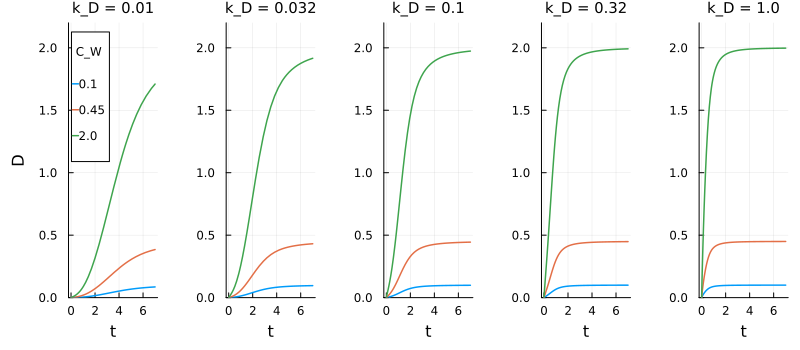

In [3]:
k_D_vec = 10 .^ range(log10(0.01), log10(1.0), 5) |> x -> round.(x, sigdigits = 2)
C_W_vec = 10 .^ range(log10(0.1), log10(2), 3) |> x -> round.(x, sigdigits = 2)

p = plot(
    layout = (1,length(k_D_vec)), 
    title = hcat(["k_D = $(k_D)" for k_D in unique(k_D_vec)]...),
    xlabel = "t",
    ylabel = ["D" "" "" "" ""],
    ylim = (0, maximum(C_W_vec) * 1.1),
    size = (800,350), 
    bottommargin = 5mm,
    leftmargin = 5mm, 
    legendtitle = "C_W \n", 
    legendtitlefontsize = 8
    )

glb = GlobalBaseParams(t_max = 7)
deb = DEBBaseParams(drc_params_G = [(1e10, 1e10)])
isolate_pmoas!(deb, ["G"])

for (i,k_D) in enumerate(k_D_vec)
    for C_W in C_W_vec
        glb.C_W = [C_W]
        deb.k_D_G = [k_D]
        out = simulator(glb, deb)
        
        @df out plot!(p, :t, :D_G_1, subplot = i, label = C_W, leg = i == 1 ? true : false)
    end
end
display(p)

## Single stressor - multiple PMoAs

In a slightly more elaborate case, we might have a single stressor which acts via multiple PMoAs.

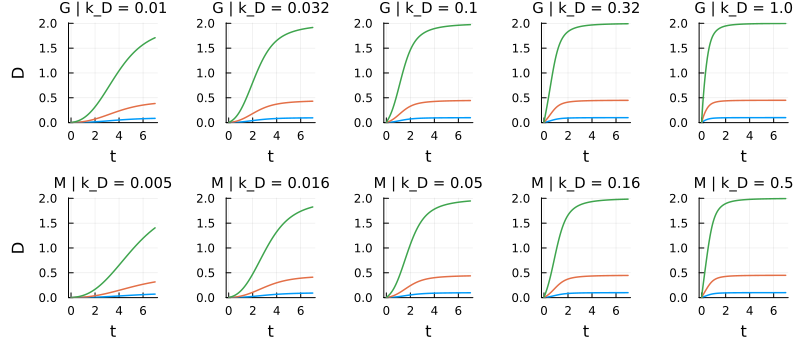

In [4]:
p = plot( # define plot
    layout = (2,length(k_D_vec)), 
    xlabel = "t",
    ylabel = ["D" "" "" "" ""],
    size = (800,350), 
    bottommargin = 5mm,
    leftmargin = 5mm, 
    ylim = (0, 2.01)
    )

for (i,k_D) in enumerate(k_D_vec)
    for C_W in C_W_vec

        glb = GlobalBaseParams(C_W = [C_W], t_max = 7)
        deb = DEBBaseParams(
            k_D_G = [k_D], # we have two PMoAs, indicated by two k_D values
            k_D_M = [k_D * .5]
            )
        out = simulator(glb, deb)
        
        @df out plot!(p, :t, :D_G_1, title = "G | k_D = $(k_D)", subplot = i)
        @df out plot!(p, :t, :D_M_1, title = "M | k_D = $(k_D/2)", subplot = i + length(k_D_vec))
    end
end
display(p)

## Multiple stressors - multiple PMoAs

Finally, we could have multiple stressors, each with mutliple PMoAs. <br>
Below we simulate TK for two stressors and two PMoAs each, as indicated by the `C_W`-Vector and `k_D`-Matrix.

In [5]:
using DEBBase

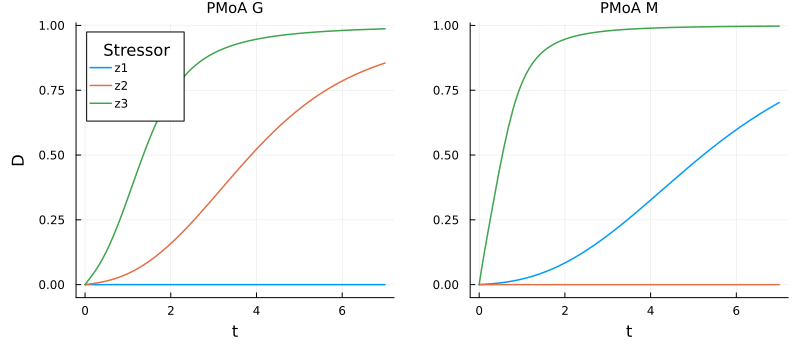

In [6]:
p = plot( # define plot
    layout = (1,2), 
    xlabel = "t",
    ylabel = ["D" "" "" "" ""],
    size = (800,350), 
    bottommargin = 5mm,
    leftmargin = 5mm, 
    ylim = (-0.05, 1.01), 
    leg = true, legendtitle = ["Stressor" nothing],
    title = ["PMoA G" "PMoA M"]
    )


glb = GlobalBaseParams(C_W = [1., 1., 1.], t_max = 7)
deb = DEBBaseParams(
    # k_D-Matrix for two PMoAs and three stressors
    k_D_G = [.0, .01, .1],
    k_D_M = [.005, .0, .5],
    drc_functs_G = [LL2, LL2M, LL2],
    drc_functs_M = [LL2, LL2M, LL2],
    drc_functs_A = [LL2, LL2M, LL2],
    drc_functs_R = [LL2, LL2M, LL2],
    drc_functs_h = [LL2, LL2M, LL2],
    drc_params_G = [(1e10, 1e10), (1e10, 1e10), (1e10, 1e10)],
    drc_params_M = [(1e10, 1e10), (1e10, 1e10), (1e10, 1e10)],
    drc_params_A = [(1e10, 1e10), (1e10, 1e10), (1e10, 1e10)],
    drc_params_R = [(1e10, 1e10), (1e10, 1e10), (1e10, 1e10)],
    drc_params_h = [(1e10, 1e10), (1e10, 1e10), (1e10, 1e10)]
    )

isolate_pmoas!(deb, ["G", "M"])
out = simulator(glb, deb)

# damage for stressor 1
@df out plot!(p, :t, :D_G_1, subplot = 1, label = "z1")
@df out plot!(p, :t, :D_M_1, subplot = 2, label = nothing)

# damage for stressor 2
@df out plot!(p, :t, :D_G_2, subplot = 1, label = "z2")
@df out plot!(p, :t, :D_M_2, subplot = 2, label = nothing)

# damage for stressor 3
@df out plot!(p, :t, :D_G_3, subplot = 1, label = "z3")
@df out plot!(p, :t, :D_M_3, subplot = 2, label = nothing)
 
display(p)

With the parameters set above, we should see that toxicokinetics increases with the stressors index, and that for each stressor, toxicokinetics for PMoA 2 is faster than for PMoA 1. 